In [57]:
from joblib import load
import torch
import torchvision
import numpy as np
from PIL import Image
from torchvision.transforms import functional as F
from skimage import feature
from torchvision.transforms.functional import to_pil_image

In [58]:
detection_model_filename = '../../model/detection.pth'
classification_model_filename = '../../model/classification.joblib'
label_filename = '../../model/label.joblib'

In [89]:
image_path ='C:/Users/Administrator/Documents/spark-plug-classification/data/classification/raw/kebocoran oli/IMG_5361.PNG'

In [82]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=91)

device = torch.device("cuda") if False else torch.device("cpu")
checkpoint = torch.load('../../model/detection.pth', map_location=device)
model.load_state_dict(checkpoint)
model.eval()

c:\Users\Administrator\Documents\spark-plug-classification\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Documents\spark-plug-classification\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6876\200923494.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [61]:
def process_image(image_path, target_size=(128, 128)):
    try:
        image = Image.open(image_path)
        
        image = image.resize(target_size)
        
        if image.mode != 'L':
            image = image.convert('L')
        
        image_tensor = F.to_tensor(image)
        image_tensor = image_tensor.unsqueeze(0) 
        
        return image_tensor
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [62]:
def extract_features_from_image(image, target_size=(128, 128)):
    try:
        image = image.resize(target_size)
        
        if image.mode != 'L':
            image = image.convert('L')
        
        image_np = np.array(image)
        
        hog_features, hog_image = feature.hog(image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
        
        return hog_features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

In [90]:
image = process_image(image_path)

if image is not None:
    with torch.no_grad():
        predictions = model(image)
    
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    image_pil = to_pil_image(image.squeeze(0))

In [91]:
for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
    if score > 0.5: 
        x1, y1, x2, y2 = map(int, box)
        cropped_image = image_pil.crop((x1, y1, x2, y2))
        # break (Jika tidak mau mendapat hasil deteksi terakhir bisa di uncomment)
    else:
        print("Objek tidak ditemukan!")

In [92]:
knn_model_loaded = load(classification_model_filename)
label_encoder_loaded = load(label_filename)

In [93]:
if cropped_image:
    hog_features = extract_features_from_image(cropped_image)
    
    if hog_features is not None:
        hog_features = hog_features.reshape(1, -1)
        
        predicted_label_encoded = knn_model_loaded.predict(hog_features)
        predicted_label = label_encoder_loaded.inverse_transform(predicted_label_encoded)

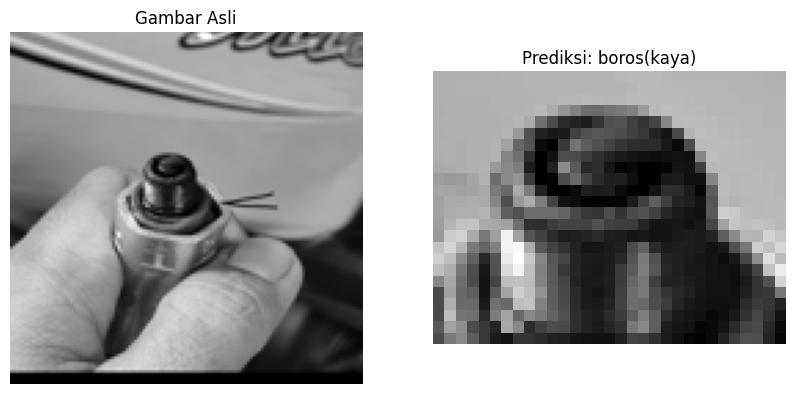

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1) 
plt.imshow(image_pil, cmap='gray')
plt.axis('off')
plt.title("Gambar Asli")

plt.subplot(1, 2, 2) 
plt.imshow(cropped_image, cmap='gray')
plt.axis('off')
plt.title(f"Prediksi: {predicted_label[0]}")

plt.show()